# CMIP6 Hackathon 2021, Charles Simpson's notebook
My task was to look at the change in average UTCI.

## Change in average UTCI
I already have resampled the data to monthly means

In [26]:
import xarray as xr
from pathlib import Path
import baspy as bp # baspy is a tool used at BAS for keeping track of the CMIP6 data
import numpy as np

utci_path = Path(
    "/gws/pw/j05/cop26_hackathons/bristol/project10/utci_projections_1deg_monthly/"
)

file_nested_list = []
model_list = []
scenario_list = []
runid_list = []

# Populate the lists from the directory structure
for model_path in utci_path.glob("*"):
    model = str(model_path).split("/")[-1]
    model_list.append(model)
    file_nested_list.append([])
    for scenario_path in model_path.glob("*"):
        scenario = str(scenario_path).split("/")[-1]
        scenario_list.append(scenario)
        file_nested_list[-1].append([])
        for runid_path in scenario_path.glob("*"):
            runid = str(runid_path).split("/")[-1]
            runid_list.append(runid)

            print(model, scenario, runid)
            file_nested_list[-1][-1].append(list(runid_path.glob("*")))

ds_scenario_results = []
for model in model_list:
    # Get the historical baseline
    scenario = "historical"
    monthly_path = list((utci_path / model / "historical").glob("*/monthly_avg.nc"))[
        0
    ]
    ds_monthly = xr.open_dataset(monthly_path)

    
    ds_baseline = ds_monthly.sel(time=slice("1986", "2016")).groupby("time.month").mean("time")

    # Get the land fraction to use as a land mask
    catlg_sftlf = bp.catalogue(
        dataset="cmip6",
        Var="sftlf",
        Model=model_list,
    ).head(1)
    ds_sftlf = xr.open_dataset(bp.get_files(catlg_sftlf)[0])
    print("The land fraction data file is:", bp.get_files(catlg_sftlf)[0])
    if ds_sftlf.lon.max() > ds_baseline.lon.max():
        ds_sftlf = ds_sftlf.assign_coords(lon=(((ds_sftlf.lon + 180) % 360) - 180))
    ds_sftlf = ds_sftlf.interp(lat=ds_baseline.lat, lon=ds_baseline.lon)

    ds_scenario_results.append([])

    # Get the scenario results
    for scenario in np.unique(scenario_list):
        if scenario == "historical":
            continue
        monthly_path = list((utci_path / model / scenario).glob("*/monthly_avg.nc"))[
            0
        ]
        ds_monthly = xr.open_dataset(monthly_path)

        ds_scenario_results[-1].append(
            (
                ds_monthly.sel(time=slice("2035", "2065")).groupby("time.month") - ds_baseline
            ).where(ds_sftlf.sftlf).mean("time")
        )
        ds_scenario_results[-1][-1] = ds_scenario_results[-1][-1].assign_coords(scenario=[scenario])
        ds_scenario_results[-1][-1] = ds_scenario_results[-1][-1].assign_coords(year=[2050])
        
        ds_scenario_results[-1].append(
            (
                ds_monthly.sel(time=slice("2070", "2100")).groupby("time.month") - ds_baseline
            ).where(ds_sftlf.sftlf).mean("time")
        )
        ds_scenario_results[-1][-1] = ds_scenario_results[-1][-1].assign_coords(scenario=[scenario])
        ds_scenario_results[-1][-1] = ds_scenario_results[-1][-1].assign_coords(year=[2085])

    ds_scenario_results[-1] = xr.combine_by_coords(ds_scenario_results[-1])#, dim="scenario")
    ds_scenario_results[-1] = ds_scenario_results[-1].assign_coords(model=[model])

ds_scenario_results = xr.combine_by_coords(ds_scenario_results)#, dim="model")

HadGEM3-GC31-LL historical r1i1p1f3
HadGEM3-GC31-LL ssp126 r1i1p1f3
HadGEM3-GC31-LL ssp245 r1i1p1f3
HadGEM3-GC31-LL ssp585 r1i1p1f3
BCC-CSM2-MR historical r1i1p1f1
BCC-CSM2-MR ssp126 r1i1p1f1
BCC-CSM2-MR ssp245 r1i1p1f1
BCC-CSM2-MR ssp585 r1i1p1f1
CMCC-ESM2 historical r1i1p1f1
CMCC-ESM2 ssp126 r1i1p1f1
CMCC-ESM2 ssp245 r1i1p1f1
CMCC-ESM2 ssp585 r1i1p1f1
The land fraction data file is: /badc/cmip6/data/CMIP6/CMIP/CMCC/CMCC-ESM2/1pctCO2/r1i1p1f1/fx/sftlf/gn/v20210114//sftlf_fx_CMCC-ESM2_1pctCO2_r1i1p1f1_gn.nc
The land fraction data file is: /badc/cmip6/data/CMIP6/CMIP/CMCC/CMCC-ESM2/1pctCO2/r1i1p1f1/fx/sftlf/gn/v20210114//sftlf_fx_CMCC-ESM2_1pctCO2_r1i1p1f1_gn.nc
The land fraction data file is: /badc/cmip6/data/CMIP6/CMIP/CMCC/CMCC-ESM2/1pctCO2/r1i1p1f1/fx/sftlf/gn/v20210114//sftlf_fx_CMCC-ESM2_1pctCO2_r1i1p1f1_gn.nc


In [27]:
ds_scenario_results.utci.attrs = {"long_name": "Change in UTCI", "short_name": "delta_utci", "units": "K"}

/home/users/champs/miniconda3/envs/hackathon/lib/python3.8/site-packages/xarray/plot/facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


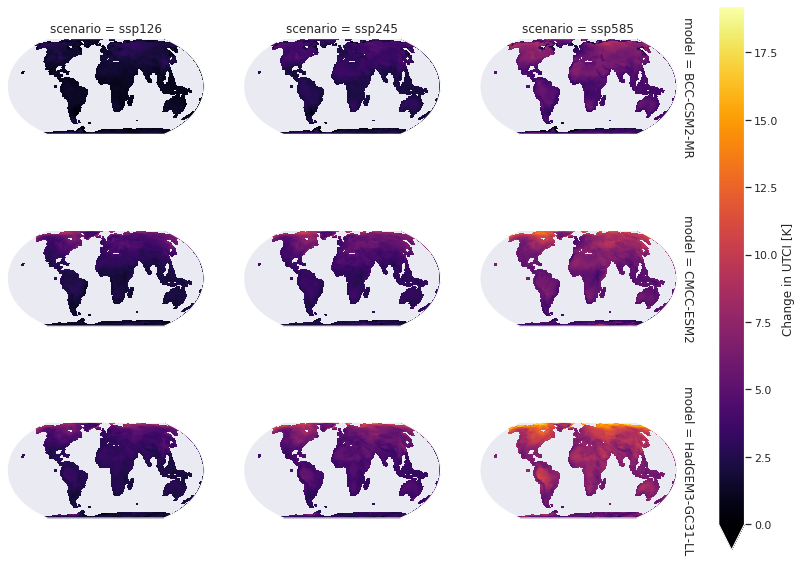

In [38]:
# Plot the maps

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

map_proj = ccrs.EqualEarth()

fg = ds_scenario_results.sel(year=[2085]).utci.plot(
    transform=ccrs.PlateCarree(),
    figsize=(15,10),
    subplot_kws={'projection': map_proj,},
    cmap='inferno',
    vmin=vmin,
    row="model", col="scenario",
)
# plt.title("2085") # doesn't work
plt.savefig("../results/charles/facet_meanchange_utci_2085_charles.png")

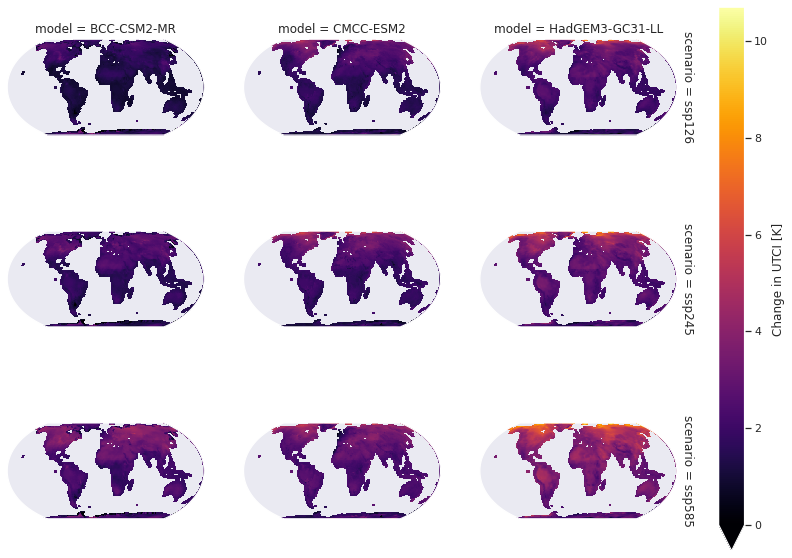

In [40]:

ds_scenario_results.sel(year=[2050]).utci.plot(
    figsize=(15,10),
    transform=ccrs.PlateCarree(),
    subplot_kws={'projection': map_proj},
    cmap='inferno',
    vmin=0,
    col="model", row="scenario"
)
# plt.title("2050")  # doesn't work
plt.savefig("../results/charles/facet_meanchange_utci_2050_charles.png")

In [30]:
pop = xr.open_dataset(
    "/gws/pw/j05/cop26_hackathons/bristol/project10/SEDAC_GPW_2020.nc"
).rename({'latitude': 'lat', 'longitude': 'lon'}).interp(lat=ds_scenario_results.lat, lon=ds_scenario_results.lon)

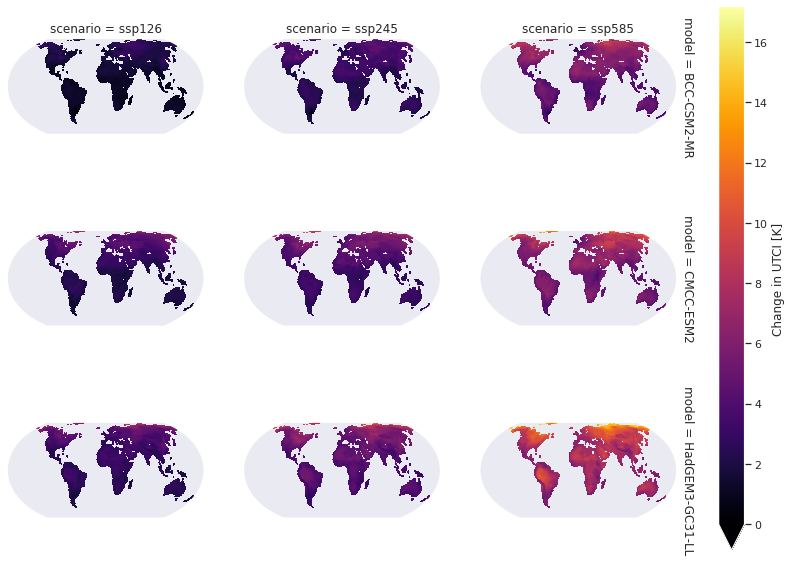

In [31]:
fg = ds_scenario_results.sel(year=[2085]).where(pop.population_density>0).utci.plot(
    transform=ccrs.PlateCarree(),
    figsize=(15,10),
    subplot_kws={'projection': map_proj,},
    cmap='inferno',
    vmin=vmin,
    row="model", col="scenario",
)
# plt.title("2085") # doesn't work
plt.savefig("../results/charles/facet_meanchange_utci_populated_2085_charles.png")

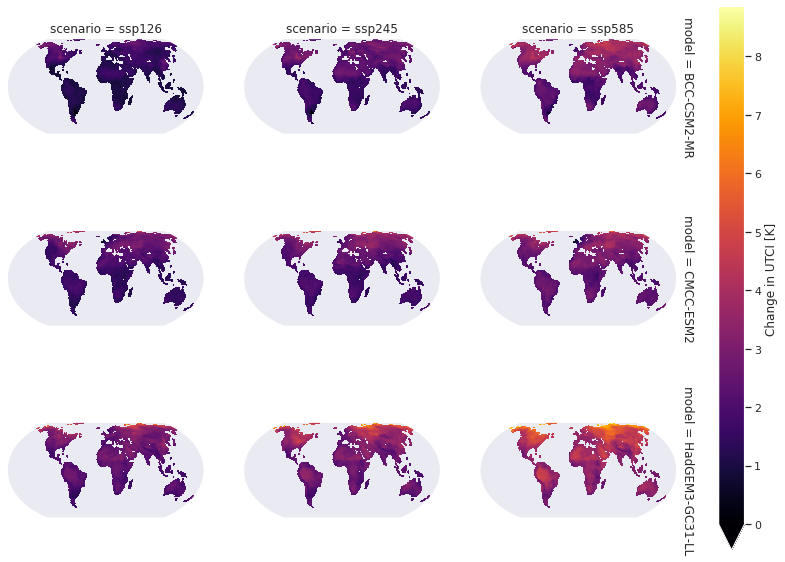

In [41]:
fg = ds_scenario_results.sel(year=[2050]).where(pop.population_density>0).utci.plot(
    transform=ccrs.PlateCarree(),
    figsize=(15,10),
    subplot_kws={'projection': map_proj,},
    cmap='inferno',
    vmin=vmin,
    row="model", col="scenario",
)

plt.savefig("../results/charles/facet_meanchange_utci_populated_2050_charles.png")

These grids show you the effect of changing between scenarios, but also the effect of changing between models.

## Local results vs GMST
Previous studies have established that heat stress metrics tend to scale with global mean surface temperatures:
* Seneviratne, S. I., Donat, M. G., Pitman, A. J., Knutti, R., & Wilby, R. L. (2016). Allowable CO2 emissions based on regional and impact-related climate targets. Nature, 529(7587), 477–483. https://doi.org/10.1038/nature16542
* Wartenburger, R., Hirschi, M., Donat, M. G., Greve, P., Pitman, A. J., & Seneviratne, S. I. (2017). Changes in regional climate extremes as a function of global mean temperature: An interactive plotting framework. Geoscientific Model Development, 10(9), 3609–3634. https://doi.org/10.5194/gmd-10-3609-2017

So let's fit a relationship between our mean *local* UTCI and and *global*-mean near-surface air temperature...

In [16]:
# This code is useful for fitting lines independently at each gridpoint.
# I think I originally got it from StackOverflow.

def new_linregress(x, y):
    """Wrapper around scipy linregress to use in apply_ufunc"""
    slope, intercept, r_value, p_value, std_err = stats.linregress(x.flatten(), y.flatten())
    return np.array([slope, intercept, r_value, p_value, std_err])


def fit_parallel_wrapper(
    x: xr.DataArray, y: xr.DataArray, dims = ["time"]
) -> xr.DataArray:
    """Do a linear fit along an axis, independently in other dimensions.
    Different outputs of the fit are arranged along a new dimension, to get
    around the limitation that xr.apply_ufunc can only take a single variable
    output.
    """
    # return a new DataArray
    result = xr.apply_ufunc(
        new_linregress,
        x,
        y,
        input_core_dims=[dims, dims],
        output_core_dims=[["linregress"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=["float64"],
        output_sizes={"parameter": 5},
    )
    result = result.assign_coords(
        {"linregress": ["slope", "intercept", "rvalue", "pvalue", "stderr"]}
    )
    return result

In [17]:
import xarray as xr
from pathlib import Path
import baspy as bp
import numpy as np
from scipy import stats

# baspy is a tool used at BAS for keeping track of the CMIP6 data
from tqdm import tqdm

utci_path = Path(
    "/gws/pw/j05/cop26_hackathons/bristol/project10/utci_projections_1deg_monthly/"
)

file_nested_list = []
model_list = []
scenario_list = []
runid_list = []

# Populate the lists from the directory structure
for model_path in utci_path.glob("*"):
    model = str(model_path).split("/")[-1]
    model_list.append(model)
    file_nested_list.append([])
    for scenario_path in model_path.glob("*"):
        scenario = str(scenario_path).split("/")[-1]
        scenario_list.append(scenario)
        file_nested_list[-1].append([])
        for runid_path in scenario_path.glob("*"):
            runid = str(runid_path).split("/")[-1]
            runid_list.append(runid)

            print(model, scenario, runid)
            file_nested_list[-1][-1].append(list(runid_path.glob("*")))
            


ds_scenario_results = []
ds_monthly_trends = []
ds_gsat = []
for model in model_list:
    print(model)
    # Get the historical baseline
    scenario = "historical"
    monthly_path = list((utci_path / model / "historical").glob("*/monthly_avg.nc"))[0]
    runid = str(monthly_path).split("/")[-2]
    ds_monthly = xr.open_dataset(monthly_path)

    ds_baseline = (
        ds_monthly
        .sel(time=slice("1986", "2016"))
        .mean(["time"])
    )

    # Get the land fraction
    catlg_sftlf = bp.catalogue(
        dataset="cmip6",
        Var="sftlf",
        Model=model_list,
    ).head(1)
    ds_sftlf = xr.open_dataset(bp.get_files(catlg_sftlf)[0])
    if ds_sftlf.lon.max() > ds_baseline.lon.max():
        ds_sftlf = ds_sftlf.assign_coords(lon=(((ds_sftlf.lon + 180) % 360) - 180))
    ds_sftlf = ds_sftlf.interp(lat=ds_baseline.lat, lon=ds_baseline.lon)

    # Get the (historical) gsat
    catlg_tas = bp.catalogue(
        dataset="cmip6",
        Experiment=scenario,
        CMOR="Amon",
        Var="tas",
        Model=model,
        RunID=runid,
    )
    ds_tas = xr.open_mfdataset(bp.get_files(catlg_tas), combine="by_coords")

    da_area = np.cos(np.deg2rad(ds_tas.lat))
    gsat_historical = ds_tas.tas.weighted(da_area).mean(["lat", "lon", "time"])
    ds_gsat.append([])

    ds_scenario_results.append([])
    

    # Get the scenario results
    for scenario in np.unique(scenario_list):
        print(scenario)
        if scenario == "historical":
            continue
        monthly_path = list((utci_path / model / scenario).glob("*/monthly_avg.nc"))[0]
        ds_monthly = xr.open_dataset(monthly_path)

        utci = (
            (ds_monthly - ds_baseline)
            .where(ds_sftlf.sftlf)
            .assign_coords(scenario=[scenario], model=[model])
        )
        ds_scenario_results[-1].append(utci)

        # Get the (scenario) gsat
        catlg_tas = bp.catalogue(
            dataset="cmip6",
            Experiment=[scenario],
            CMOR="Amon",
            Var="tas",
            Model=[model],
            RunID=[runid],
        )

        ds_tas = xr.open_mfdataset(bp.get_files(catlg_tas), combine="by_coords")

        gsat = (
            ds_tas.tas.weighted(da_area)
            .mean(["lat", "lon"])
            .groupby('time.year')
            .mean()
            .assign_coords(scenario=scenario, model=model)
            .expand_dims(("scenario", "model"))
            - gsat_historical
        ).to_dataset(name='gsat')
        ds_gsat[-1].append(gsat)
#         breakpoint()

    ds_scenario_results[-1] = xr.combine_by_coords(ds_scenario_results[-1])
    ds_gsat[-1] = xr.combine_by_coords(ds_gsat[-1])
    
    monthly_trends = ds_scenario_results[-1].utci.groupby("time.month").apply(
        lambda x: fit_parallel_wrapper(
            ds_gsat[-1].gsat.load(),
            x.groupby("time.year").mean().sel(year=gsat.year).load(),
            ["scenario", "year"],
        )
    )
    ds_monthly_trends.append(monthly_trends)
        

HadGEM3-GC31-LL historical r1i1p1f3
HadGEM3-GC31-LL ssp126 r1i1p1f3
HadGEM3-GC31-LL ssp245 r1i1p1f3
HadGEM3-GC31-LL ssp585 r1i1p1f3
BCC-CSM2-MR historical r1i1p1f1
BCC-CSM2-MR ssp126 r1i1p1f1
BCC-CSM2-MR ssp245 r1i1p1f1
BCC-CSM2-MR ssp585 r1i1p1f1
CMCC-ESM2 historical r1i1p1f1
CMCC-ESM2 ssp126 r1i1p1f1
CMCC-ESM2 ssp245 r1i1p1f1
CMCC-ESM2 ssp585 r1i1p1f1
HadGEM3-GC31-LL
historical
ssp126
ssp245
ssp585


<ipython-input-16-b089a69f15f7>:16: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  result = xr.apply_ufunc(
<ipython-input-16-b089a69f15f7>:16: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  result = xr.apply_ufunc(
<ipython-input-16-b089a69f15f7>:16: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  result = xr.apply_ufunc(
<ipython-input-16-b089a69f15f7>:16: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  result = xr.apply_ufunc(
<ipython-input-16-b089a69f15f7>:16: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direc

BCC-CSM2-MR
historical
ssp126
ssp245
ssp585


<ipython-input-16-b089a69f15f7>:16: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  result = xr.apply_ufunc(
<ipython-input-16-b089a69f15f7>:16: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  result = xr.apply_ufunc(
<ipython-input-16-b089a69f15f7>:16: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  result = xr.apply_ufunc(
<ipython-input-16-b089a69f15f7>:16: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  result = xr.apply_ufunc(
<ipython-input-16-b089a69f15f7>:16: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direc

CMCC-ESM2
historical
ssp126
ssp245
ssp585


<ipython-input-16-b089a69f15f7>:16: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  result = xr.apply_ufunc(
<ipython-input-16-b089a69f15f7>:16: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  result = xr.apply_ufunc(
<ipython-input-16-b089a69f15f7>:16: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  result = xr.apply_ufunc(
<ipython-input-16-b089a69f15f7>:16: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  result = xr.apply_ufunc(
<ipython-input-16-b089a69f15f7>:16: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direc

In [18]:
ds_monthly_trends = xr.concat(ds_monthly_trends, dim='model')

In [19]:
ds_monthly_trends.to_netcdf("ds_monthly_trends.nc")

Text(0.5, 1.0, 'R^2')

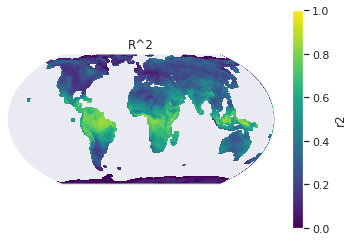

In [42]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import xarray as xr

map_proj = ccrs.EqualEarth()
ds_monthly_trends = xr.open_dataset("ds_monthly_trends.nc").rename(__xarray_dataarray_variable__="fit")
data = ds_monthly_trends.sel(linregress="rvalue")
data["r2"] = data.fit**2
data.r2.median('model').min("month").plot(
    transform=ccrs.PlateCarree(),
    subplot_kws={"projection": map_proj},
    vmin=0, vmax=1, cmap='viridis'
    
)
plt.savefig("../results/charles/gsat_utci_rvalue_mmmed_minmonth_charles.png")
plt.title("R^2")

Generally, there is less interannual variation in air temperatures near the equator, meaning that the UTCI near the equator is more strongly correlated with GSAT.

Actually, the absolute change in UTCI is larger higher latitudes, but the interannual variability is larger.

/home/users/champs/miniconda3/envs/hackathon/lib/python3.8/site-packages/xarray/plot/facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


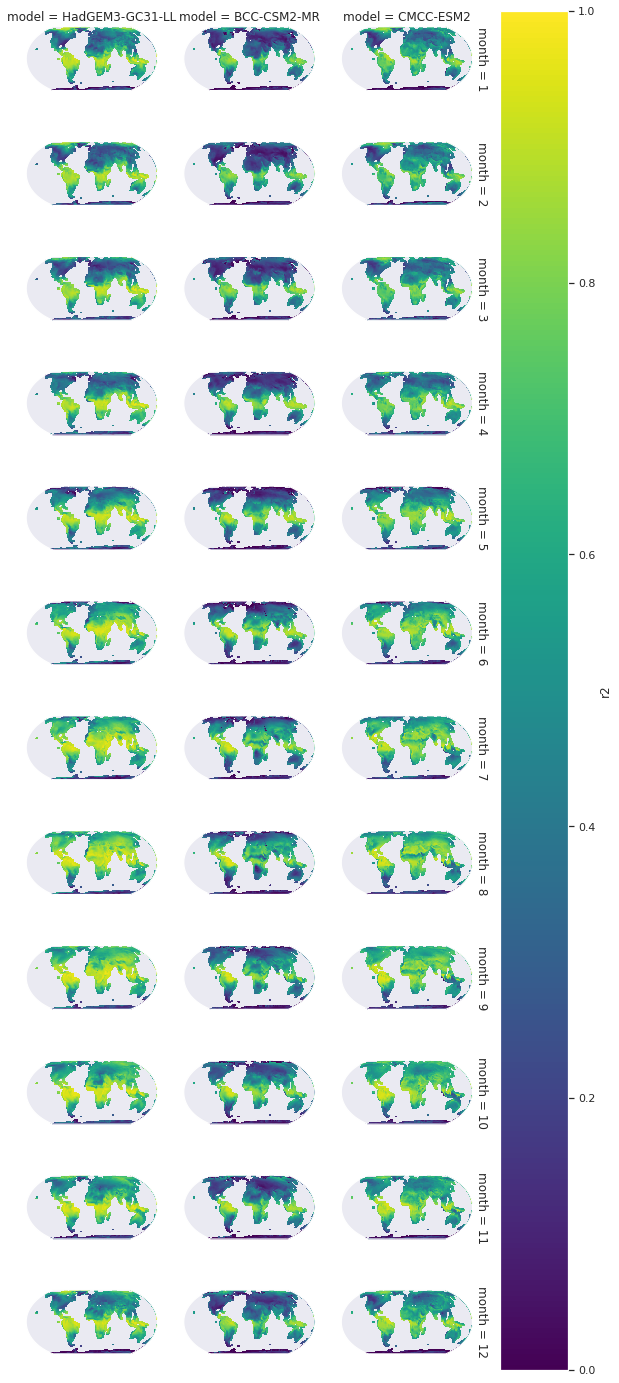

In [43]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import xarray as xr

map_proj = ccrs.EqualEarth()
ds_monthly_trends = xr.open_dataset("ds_monthly_trends.nc").rename(__xarray_dataarray_variable__="fit")
data = ds_monthly_trends.sel(linregress="rvalue")
data["r2"] = data.fit**2
data.r2.plot(
    col="model", row="month",
    figsize=(10,25),
    transform=ccrs.PlateCarree(),
    subplot_kws={"projection": map_proj},
    vmin=0, vmax=1, cmap='viridis'
    
)
plt.savefig("../results/charles/gsat_utci_rvalue_charles.png")

This grid shows how strongly mean *local* UTCI is correlated with *global*-mean SAT. A high number means that changes in UTCI are mostly explained by changes in GSAT.

BCC-CSM is the least sensitive of these models, so the effect of interannual variability will be stronger compared to the GSAT trend, which probably explains why the correlateion between UTCI and GSAT is weaker.

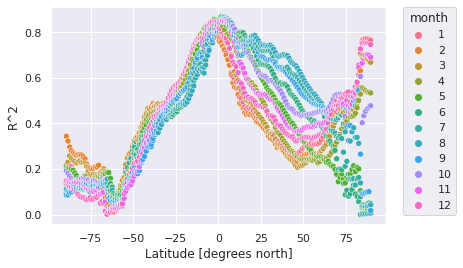

In [44]:
import seaborn as sns; sns.set_theme()
sns.set_color_codes("colorblind")
data = ds_monthly_trends.sel(linregress='rvalue').mean(("lon", "model")).to_dataframe().reset_index()
data["month_str"] = data.month.astype("str")
data["r2"] = data.fit**2
sns.scatterplot(data=data,
                x="lat", y="r2", hue="month_str", 
               )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="month")
plt.ylabel("R^2")
plt.xlabel("Latitude [degrees north]")
plt.savefig("../results/charles/gsat_utci_rvalue_latitude_charles.png")

The polar regions have a lot of variability.
The interannual variability in the Northern hemisphere seems to be largest in the the winter. The Southern hemisphere seems to have less difference in interannual variability between months.

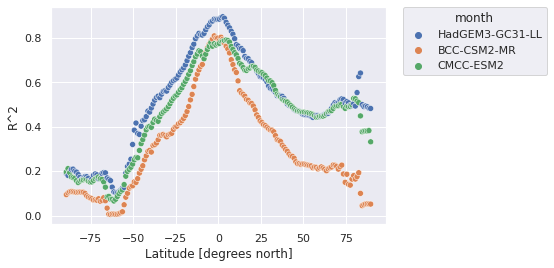

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
sns.set_color_codes("colorblind")
data = ds_monthly_trends.sel(linregress='rvalue').mean(("lon", "month")).to_dataframe().reset_index()

data["r2"] = data.fit**2
sns.scatterplot(data=data,
                x="lat", y="r2", hue="model", 
               )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="month")
plt.ylabel("R^2")
plt.xlabel("Latitude [degrees north]")
plt.savefig("../results/charles/gsat_utci_rvalue_latitude_charles.png")

There are quite large differences between the models.
A large part of this is probably just due to climate sensitivity. BCC is the least sensitive, so the GSAT trend is weaker compared to interannual variability.

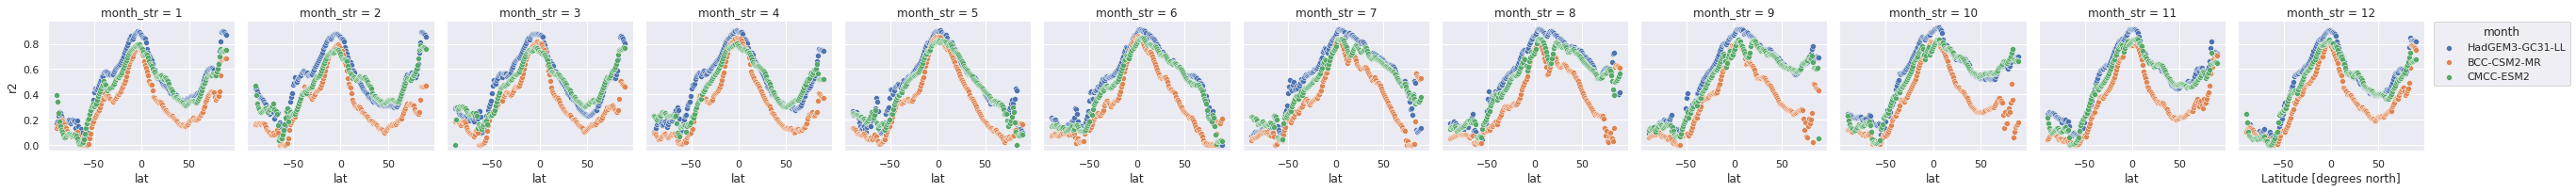

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
sns.set_color_codes("colorblind")
data = ds_monthly_trends.sel(linregress='rvalue').mean(("lon")).to_dataframe().reset_index()
data["month_str"] = data.month.astype("str")
data["r2"] = data.fit**2

g = sns.FacetGrid(data, col="month_str", hue="model", margin_titles=True)
g.map(sns.scatterplot, "lat", "r2",)


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="month")
plt.ylabel("R^2")
plt.xlabel("Latitude [degrees north]")
plt.savefig("../results/charles/utci_gsat_r2_monthly_charles.png")

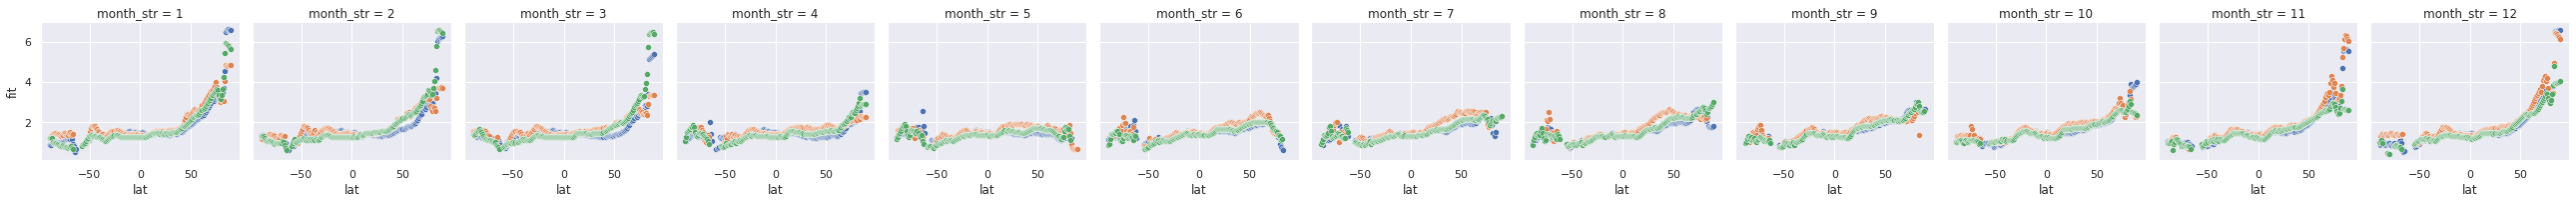

In [47]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns; sns.set_theme()

map_proj = ccrs.EqualEarth()
ds_monthly_trends = xr.open_dataset("ds_monthly_trends.nc").rename(__xarray_dataarray_variable__="fit")



sns.set_color_codes("colorblind")
data = ds_monthly_trends.where(ds_monthly_trends.sel(linregress="rvalue")>0.4).sel(linregress='slope').mean(("lon")).to_dataframe().reset_index()
data["month_str"] = data.month.astype("str")

g = sns.FacetGrid(data, col="month_str", hue="model", margin_titles=True)
g.map(sns.scatterplot, "lat", "fit",)
plt.savefig("../results/charles/utci_gsat_slope_monthly_charles.png")

## Repeating the trend plots with just populated areas

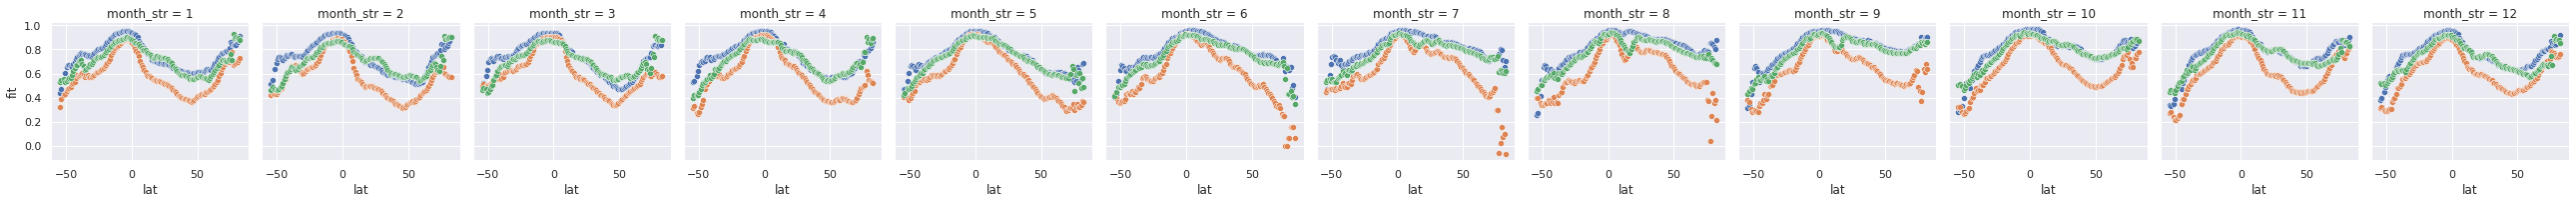

In [18]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns

sns.set_theme()

map_proj = ccrs.EqualEarth()
ds_monthly_trends = xr.open_dataset("ds_monthly_trends.nc").rename(
    __xarray_dataarray_variable__="fit"
)
pop = xr.open_dataset(
    "/gws/pw/j05/cop26_hackathons/bristol/project10/SEDAC_GPW_2020.nc"
).rename({'latitude': 'lat', 'longitude': 'lon'}).interp(lat=ds_monthly_trends.lat, lon=ds_monthly_trends.lon)


sns.set_color_codes("colorblind")
data = ds_monthly_trends.where(pop.population_density > 0)
data = (
    data
    .sel(linregress="rvalue")
    .mean(("lon"))
    .to_dataframe()
    .reset_index()
)
data["r2"] = data.fit**2
data["month_str"] = data.month.astype("str")

g = sns.FacetGrid(data, col="month_str", hue="model", margin_titles=True)
g.map(
    sns.scatterplot,
    "lat",
    "fit",
)
plt.savefig("../results/charles/utci_gsat_rvalue_monthly_populated.png")

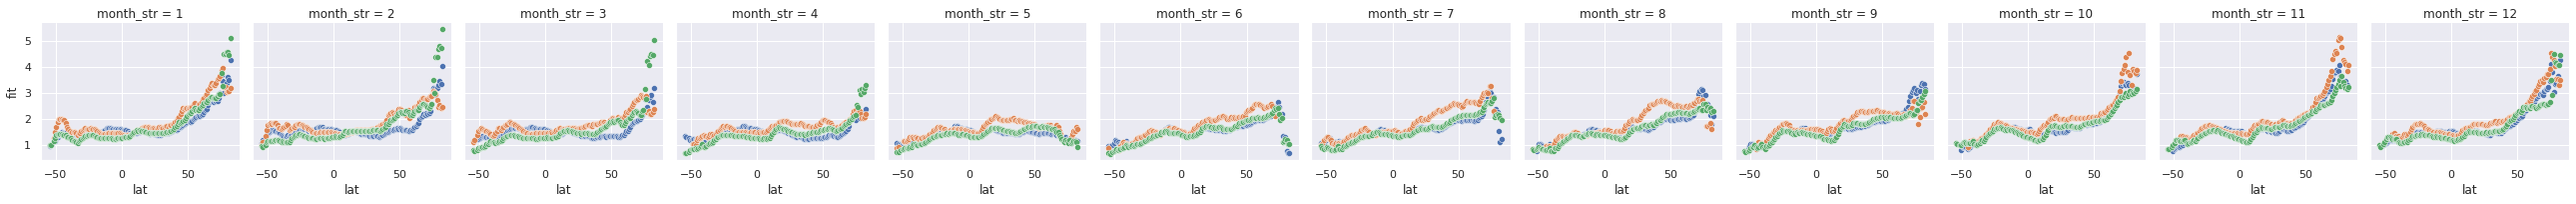

In [20]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns

sns.set_theme()

map_proj = ccrs.EqualEarth()
ds_monthly_trends = xr.open_dataset("ds_monthly_trends.nc").rename(
    __xarray_dataarray_variable__="fit"
)
pop = xr.open_dataset(
    "/gws/pw/j05/cop26_hackathons/bristol/project10/SEDAC_GPW_2020.nc"
).rename({'latitude': 'lat', 'longitude': 'lon'}).interp(lat=ds_monthly_trends.lat, lon=ds_monthly_trends.lon)


sns.set_color_codes("colorblind")
data = ds_monthly_trends.where(pop.population_density > 0)
data = (
    data.where(data.sel(linregress="rvalue").fit>0.4)
    .sel(linregress="slope")
    .mean(("lon"))
    .to_dataframe()
    .reset_index()
)
data["r2"] = data.fit**2
data["month_str"] = data.month.astype("str")

g = sns.FacetGrid(data, col="month_str", hue="model", margin_titles=True)
g.map(
    sns.scatterplot,
    "lat",
    "fit",
)
plt.savefig("../results/charles/utci_gsat_slope_monthly_populated.png")

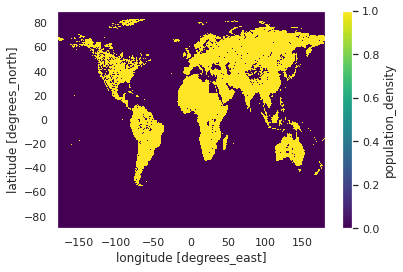

In [13]:
(pop.population_density > 0).plot()

In [21]:
def new_linregress(x, y):
    """Wrapper around scipy linregress to use in apply_ufunc"""
    slope, intercept, r_value, p_value, std_err = stats.linregress(x.flatten(), y.flatten())
    return np.array([slope, intercept, r_value, p_value, std_err])


def fit_parallel_wrapper(
    x: xr.DataArray, y: xr.DataArray, dims = ["time"]
) -> xr.DataArray:
    """Do a linear fit along an axis, independently in other dimensions.
    Different outputs of the fit are arranged along a new dimension, to get
    around the limitation that xr.apply_ufunc can only take a single variable
    output.
    """
    # return a new DataArray
    result = xr.apply_ufunc(
        new_linregress,
        x,
        y,
        input_core_dims=[dims, dims],
        output_core_dims=[["linregress"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=["float64"],
        output_sizes={"parameter": 5},
    )
    result = result.assign_coords(
        {"linregress": ["slope", "intercept", "rvalue", "pvalue", "stderr"]}
    )
    return result

## Repeating the trend analysis with 9th percentile data

In [22]:
# Can we repeat the trend analysis with the 95th percentile data?

import xarray as xr
from pathlib import Path
import baspy as bp
import numpy as np
from scipy import stats

# baspy is a tool used at BAS for keeping track of the CMIP6 data
from tqdm import tqdm

utci_path = Path(
    "/gws/pw/j05/cop26_hackathons/bristol/project10/utci_projections_1deg_monthly95pc/"
)

file_nested_list = []
model_list = []
scenario_list = []
runid_list = []

# Populate the lists from the directory structure
for model_path in utci_path.glob("*"):
    model = str(model_path).split("/")[-1]
    model_list.append(model)
    file_nested_list.append([])
    for scenario_path in model_path.glob("*"):
        scenario = str(scenario_path).split("/")[-1]
        scenario_list.append(scenario)
        file_nested_list[-1].append([])
        for runid_path in scenario_path.glob("*"):
            runid = str(runid_path).split("/")[-1]
            runid_list.append(runid)

            print(model, scenario, runid)
            file_nested_list[-1][-1].append(list(runid_path.glob("*")))
            


ds_scenario_results = []
ds_monthly_trends = []
ds_gsat = []
for model in ["HadGEM3-GC31-LL"]:
    print(model)
    # Get the historical baseline
    scenario = "historical"
    monthly_path = list((utci_path / model / "historical").glob("*/monthly_95pc.nc"))[0]
    runid = str(monthly_path).split("/")[-2]
    ds_monthly = xr.open_dataset(monthly_path)

    ds_baseline = (
        ds_monthly
        .sel(time=slice("1986", "2016"))
        .mean(["time"])
    )

    # Get the land fraction
    catlg_sftlf = bp.catalogue(
        dataset="cmip6",
        Var="sftlf",
        Model=model_list,
    ).head(1)
    ds_sftlf = xr.open_dataset(bp.get_files(catlg_sftlf)[0])
    if ds_sftlf.lon.max() > ds_baseline.lon.max():
        ds_sftlf = ds_sftlf.assign_coords(lon=(((ds_sftlf.lon + 180) % 360) - 180))
    ds_sftlf = ds_sftlf.interp(lat=ds_baseline.lat, lon=ds_baseline.lon)

    # Get the (historical) gsat
    catlg_tas = bp.catalogue(
        dataset="cmip6",
        Experiment=scenario,
        CMOR="Amon",
        Var="tas",
        Model=model,
        RunID=runid,
    )
    ds_tas = xr.open_mfdataset(bp.get_files(catlg_tas), combine="by_coords")

    da_area = np.cos(np.deg2rad(ds_tas.lat))
    gsat_historical = ds_tas.tas.weighted(da_area).mean(["lat", "lon", "time"])
    ds_gsat.append([])

    ds_scenario_results.append([])
    

    # Get the scenario results
    for scenario in np.unique(scenario_list):
        print(scenario)
        if scenario == "historical":
            continue
        monthly_path = list((utci_path / model / scenario).glob("*/monthly_95pc.nc"))[0]
        ds_monthly = xr.open_dataset(monthly_path)

        utci = (
            (ds_monthly - ds_baseline)
            .where(ds_sftlf.sftlf)
            .assign_coords(scenario=[scenario], model=[model])
        )
        ds_scenario_results[-1].append(utci)

        # Get the (scenario) gsat
        catlg_tas = bp.catalogue(
            dataset="cmip6",
            Experiment=[scenario],
            CMOR="Amon",
            Var="tas",
            Model=[model],
            RunID=[runid],
        )

        ds_tas = xr.open_mfdataset(bp.get_files(catlg_tas), combine="by_coords")

        gsat = (
            ds_tas.tas.weighted(da_area)
            .mean(["lat", "lon"])
            .groupby('time.year')
            .mean()
            .assign_coords(scenario=scenario, model=model)
            .expand_dims(("scenario", "model"))
            - gsat_historical
        ).to_dataset(name='gsat')
        ds_gsat[-1].append(gsat)
#         breakpoint()

    ds_scenario_results[-1] = xr.combine_by_coords(ds_scenario_results[-1])
    ds_gsat[-1] = xr.combine_by_coords(ds_gsat[-1])
    
    monthly_trends = ds_scenario_results[-1].utci.groupby("time.month").apply(
        lambda x: fit_parallel_wrapper(
            ds_gsat[-1].gsat.load(),
            x.groupby("time.year").mean().sel(year=gsat.year).load(),
            ["scenario", "year"],
        )
    )
    ds_monthly_trends.append(monthly_trends)
        

HadGEM3-GC31-LL historical r1i1p1f3
HadGEM3-GC31-LL ssp126 r1i1p1f3
HadGEM3-GC31-LL ssp245 r1i1p1f3
HadGEM3-GC31-LL ssp585 r1i1p1f3
HadGEM3-GC31-LL
historical
ssp126
ssp245
ssp585


<ipython-input-21-b089a69f15f7>:16: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  result = xr.apply_ufunc(
<ipython-input-21-b089a69f15f7>:16: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  result = xr.apply_ufunc(
<ipython-input-21-b089a69f15f7>:16: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  result = xr.apply_ufunc(
<ipython-input-21-b089a69f15f7>:16: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  result = xr.apply_ufunc(
<ipython-input-21-b089a69f15f7>:16: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direc

In [23]:
ds_monthly_trends = xr.concat(ds_monthly_trends, dim='model').to_dataset(name="fit")

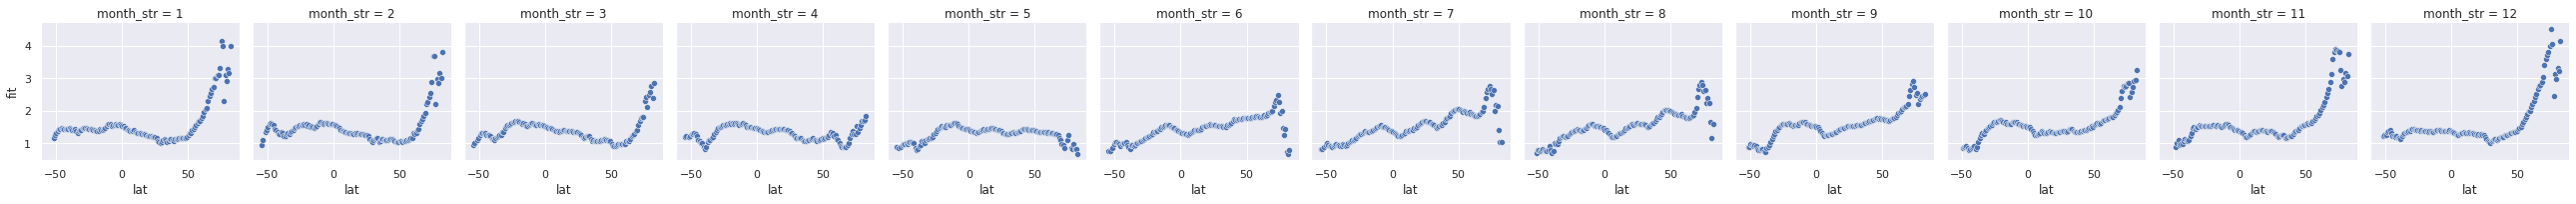

In [33]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns

sns.set_theme()

map_proj = ccrs.EqualEarth()

pop = xr.open_dataset(
    "/gws/pw/j05/cop26_hackathons/bristol/project10/SEDAC_GPW_2020.nc"
).rename({'latitude': 'lat', 'longitude': 'lon'}).interp(lat=ds_monthly_trends.lat, lon=ds_monthly_trends.lon)


sns.set_color_codes("colorblind")
data = ds_monthly_trends.where(pop.population_density > 0)
data = (
    data.where(data.sel(linregress="rvalue").fit>0.4)
    .sel(linregress="slope")
    .mean(("lon"))
    .to_dataframe()
    .reset_index()
)
data["r2"] = data.fit**2
data["month_str"] = data.month.astype("str")

g = sns.FacetGrid(data, col="month_str", hue="model", margin_titles=True)
g.map(
    sns.scatterplot,
    "lat",
    "fit",
)
plt.savefig("../results/charles/utci95pc_gsat_slope_monthly_populated.png")

/home/users/champs/miniconda3/envs/hackathon/lib/python3.8/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)
/home/users/champs/miniconda3/envs/hackathon/lib/python3.8/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)
No handles with labels found to put in legend.


Text(0.5, 0, 'Latitude [degrees north]')

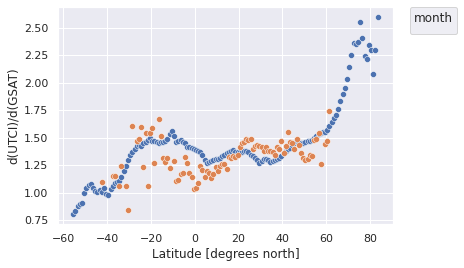

In [89]:
data = ds_monthly_trends.where(pop.population_density.pipe(np.isnan).pipe(np.logical_not)).sel(linregress='slope').mean(("lon", "month")).to_dataframe().reset_index()

data["r2"] = data.fit**2
sns.scatterplot(data=data,
                x="lat", y="fit",
               )

data = ds_monthly_trends.where(pop.population_density > pop.population_density.quantile(0.95)).sel(linregress='slope').mean(("lon", "month")).to_dataframe().reset_index()
data["r2"] = data.fit**2
sns.scatterplot(data=data,
                x="lat", y="fit", 
               )

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="month")
plt.ylabel("d(UTCI)/d(GSAT)")
plt.xlabel("Latitude [degrees north]")


/home/users/champs/miniconda3/envs/hackathon/lib/python3.8/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)
/home/users/champs/miniconda3/envs/hackathon/lib/python3.8/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)


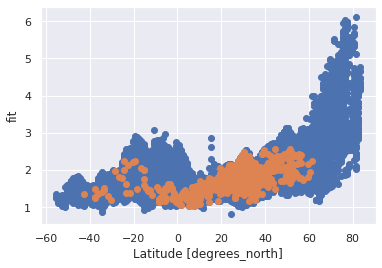

In [95]:
data = ds_monthly_trends.where(pop.population_density.pipe(np.isnan).pipe(np.logical_not)).sel(linregress='slope').max("month")
data.plot.scatter("lat", "fit")

data = ds_monthly_trends.where(pop.population_density > pop.population_density.quantile(0.95)).sel(linregress='slope').max("month")
data.plot.scatter("lat", "fit")


What about the 95pc vs the mean?